In [1]:
import time
import numpy as np 
import pandas as pd
import math
import random

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

array([-1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
        1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1.,
       -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1.,  1.,  1.])

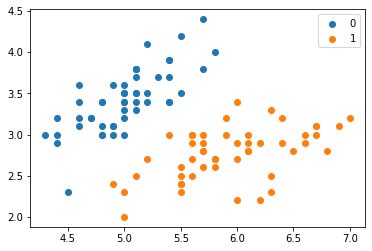

In [2]:
# 数据准备阶段
# 加载数据进行测试
iris = load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['label'] = iris.target
df.columns = [
     'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
]
df[df == 0] = -1
data = np.array(df.iloc[:100, [0, 1, -1]]) # 取前两类
X, y = data[:, :2], data[:, -1]  # X只取两个维度

## 对数据进行随机化
def shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]

data_X, data_y = shuffle(X, y)
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_y, test_size = 0.3)

plt.scatter(X[:50, 0], X[:50, 1], label = '0')
plt.scatter(X[50:, 0], X[50:, 1], label = '1')
plt.legend()
Y_train # 是一个array

In [19]:
# SVM 类
    # 相关参数初始化
    # func2. 计算核函数 返回高斯核矩阵（即所有变量间的核函数）
    # func3. 判断是否满足KKT条件
    # func4. 计算g（xi）= wx+b
    # func5. 计算Ei
    # func6. 获得第二个变量 alpha 2
    # func7. 训练函数
    # func8. 单独计算两个变量之间的核函数 我觉得不需要
    # func8. 预测函数
    # func9. 测试函数

class SVM:
    def __init__(self, X_train, Y_train, sigma = 10, C = 200, toler = 0.001, iter_times = 300):
        '''
        参数初始化：
        X_train: 训练数据集 numpy array 格式
        Y_trian: 训练标签集 numpy array 格式
        sigma: 高斯核中的参数
        C: 惩罚参数
        toler: 松弛变量
        '''
        self.X_train = X_train
        self.Y_train = Y_train
        self.m, self.n = np.shape(X_train)   # m 为训练集中的数据个数， n为数据的维度
        self.sigma = sigma
        self.C = C
        self.toler = toler
        self.iter_times = iter_times
        
        self.k = self.calcKernel()                # 核函数初始化
        self.b = 0.
        self.alpha = np.zeros_like(Y_train)          # 目标函数的参数，要学习的参数
        self.Ei = np.zeros_like(Y_train)               # Ei g(xi) 与 yi的差值
        self.supportIndex = []                   # 用来存储支持向量
    
    def calcKernel(self): 
        '''
        计算高斯核函数，并返回高斯核函数矩阵
        '''
        kernel = np.empty([self.m, self.m], dtype = float)  # 初始化高斯核矩阵
        
        # 该矩阵是对称的，所以只需要计算一半就行了
        for i in range(self.m):
            for j in range(i, self.m):
                kernel[i][j] = np.exp( - (np.linalg.norm(self.X_train[i] - self.X_train[j], ord=2) ** 2) / (2 * self.sigma**2) )
                kernel[j][i] = kernel[i][j]
        
        return kernel
    
    def isSatisfyKTT(self, i):
        '''
        查看第下标为i的alpha是否满足KTT条件
        '''
        gxi = self.calc_gxi(i)
        yi = self.Y_train[i]
        
        if (math.fabs(self.alpha[i]) < self.toler) and (yi * gxi  >= 1):
            return True
        elif (self.alpha[i] > -self.toler and self.alpha[i] < self.C + self.toler) and \
             (math.fabs(gxi * yi - 1) < self.toler):
            return True
        elif (math.fabs(self.alpha[i] - self.C) < self.toler) and (yi * gxi <= 1):
            return True
        
        return False
    
    def calc_gxi(self, i):
        return sum(self.alpha * self.Y_train * self.k[i]) + self.b
        # 但是怎么算有一个缺点，没有考虑alpha = 0 的x不需要算，也就是如果要提高计算效率，应该只考虑支持向量，也就是alpha ！= 0 的点
    
    def calcEi(self, i):
        gxi = self.calc_gxi(i)
        return gxi - self.Y_train[i]
    
    def getAlpha(self, E1, i):
        '''
        E1: 第一个alpha的 E1
        i: 第一个alpha的下标
        return: 第二个alpha， 第二个alpha的下标
        '''
        # 初始化
        E2 = 0
        # 初始化
        maxE1_E2 = -1  
        # 初始化 第二个变量的下标
        maxIndex = -1  
        
        nozeroEi = [i for i, Ei in enumerate(self.Ei) if Ei != 0]
        for j in np.arange(len(nozeroEi)):
            E2_temp = self.calcEi(j)
            if math.fabs(E2_temp - E1) > maxE1_E2:
                maxE1_E2 = math.fabs(E2_temp - E1)
                E2 = E2_temp
                maxIndex = j
        if maxIndex == -1: # 对应刚开始的时候，如果列表中没有非0元素了
            maxIndex = i
            while (maxIndex == i):
                maxIndex = int(random.uniform(0, self.m))
            E2 = self.calcEi(maxIndex)
        
        return E2, maxIndex
    
    def train(self):
        iterStep = 0; parameterChange = 1
        # iterStep迭代次数
        # parameterChange 参数改变次数，parameterChange==0表示上次迭代中参数没有发生变化，如果参数没有发生变化则训练终止
        while (iterStep < self.iter_times) and (parameterChange > 0):
            iterStep += 1
            parameterChange = 0
            
            # 大循环用于寻找第一个变量
            for i in range(self.m):
                # 如果不满足KKT条件
                if self.isSatisfyKTT(i) == False: # 这里寻找第一个变量的方法是直接遍历，而非量化违反KTT条件，去寻找最严重的那一个
                    E1 = self.calcEi(i)
                    E2, j = self.getAlpha(E1, i)
                
                    y1 = self.Y_train[i]
                    y2 = self.Y_train[j]
                    
                    oldAlpha1 = self.alpha[i]
                    oldAlpha2 = self.alpha[j]
                    
                    if y1 != y2:
                        L = max(0., oldAlpha2 - oldAlpha1)
                        H = min(self.C, self.C + oldAlpha2 - oldAlpha1)
                    else:
                        L = max(0., oldAlpha2 + oldAlpha1 - self.C)
                        H = min(self.C, oldAlpha2 + oldAlpha1)
                    
                    # 如果L==H，说明该变量无法在优化，直接跳到下一个循环
                    if L == H:  continue
                    
                    K11 = self.k[i][i]
                    K22 = self.k[j][j]
                    K12 = self.k[i][j]
                    K21 = self.k[j][i]
                    
                    # 计算未经剪辑的alpha2
                    newAlpha2 = oldAlpha2 + y2 * (E1 - E2) / (K11 + K22 - 2 * K12)
                    
                    # 对alpha2进行剪辑
                    if newAlpha2 > H:  newAlpha2 = H
                    if newAlpha2 < L:  newAlpha2 = L
                        
                    # 计算alpha1
                    newAlpha1 = oldAlpha1 + y1 * y2 * (oldAlpha2 - newAlpha2)
                    
                    # 在完成两个alpha的更新后，需要更新参数b
                    newb1 = - E1 - y1 * K11 * (newAlpha1 - oldAlpha1) - \
                            y2 * K21 * (newAlpha2 - oldAlpha2) + self.b
                    newb2 = - E2 - y1 * K12 * (newAlpha1 - oldAlpha1) - \
                            y2 * K22 * (newAlpha2 - oldAlpha2) + self.b
                    
                    if (newAlpha1 > 0) and (newAlpha1 < self.C):
                        newb = newb1
                    elif (newAlpha2 > 0) and (newAlpha2 < self.C):
                        newb = newb2
                    else:
                        newb = (newb1 + newb2) / 2
                    
                    # 更新完 alpha 和 b之后，先存储，方便之后更新E
                    self.alpha[i] = newAlpha1
                    self.alpha[j] = newAlpha2
                    self.b = newb
                    # 除了要更新b之外，还需要更新对应的Ei的值，并将它们保存在列表中
                    
                    self.Ei[i] = self.calcEi(i)
                    self.Ei[j] = self.calcEi(j)
                    
                    if (math.fabs(oldAlpha2 - newAlpha2) >= 0.00001):
                        parameterChange += 1
        # 保存支持向量，当数据量很大时可以用来优化
        for i in range(self.m):
            if self.alpha[i] > 0:
                self.supportIndex.append(i)
                
    def calcSingleKernel(self, x1, x2):
        '''
        x1: array
        x2: array
        '''
        result = np.exp( - (np.linalg.norm(x1 - x2, ord=2) ** 2) / (self.sigma ** 2) )
        return result
    
    def predict(self, X_test):
        '''
        X_test: 预测数据集，格式numpy array
        return 预测结果 numpy array 数组
        '''
        result = np.empty([len(X_test)], dtype = float)
        K_x_xi = np.empty([self.m], dtype=float)
        for j in range(len(X_test)):
            for i in range(self.m):
                K_x_xi[i] = self.calcSingleKernel(X_test[j], self.X_train[i])
            result[j] = np.sum(self.alpha * self.Y_train * K_x_xi) + self.b
        
        return np.sign(result)
    
    def score(self, X_test, Y_test):
        prediction = self.predict(X_test)
        right_count = 0
        for i in range(len(Y_test)):
            if prediction[i] == Y_test[i]:
                right_count += 1
                
        return right_count / len(Y_test)


In [20]:
svm = SVM(X_train, Y_train)

In [21]:
svm.train()

In [24]:
result = svm.predict(X_test)
result

array([ 1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1., -1.])

In [25]:
svm.score(X_test, Y_test)

1.0

### sklearn.svm.SVC

*(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False,tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None,random_state=None)*

参数：

- C：C-SVC的惩罚参数C?默认值是1.0

C越大，相当于惩罚松弛变量，希望松弛变量接近0，即对误分类的惩罚增大，趋向于对训练集全分对的情况，这样对训练集测试时准确率很高，但泛化能力弱。C值小，对误分类的惩罚减小，允许容错，将他们当成噪声点，泛化能力较强。

- kernel ：核函数，默认是rbf，可以是‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
    
    – 线性：u'v
    
    – 多项式：(gamma*u'*v + coef0)^degree

    – RBF函数：exp(-gamma|u-v|^2)

    – sigmoid：tanh(gamma*u'*v + coef0)


- degree ：多项式poly函数的维度，默认是3，选择其他核函数时会被忽略。


- gamma ： ‘rbf’,‘poly’ 和‘sigmoid’的核函数参数。默认是’auto’，则会选择1/n_features


- coef0 ：核函数的常数项。对于‘poly’和 ‘sigmoid’有用。


- probability ：是否采用概率估计？.默认为False


- shrinking ：是否采用shrinking heuristic方法，默认为true


- tol ：停止训练的误差值大小，默认为1e-3


- cache_size ：核函数cache缓存大小，默认为200


- class_weight ：类别的权重，字典形式传递。设置第几类的参数C为weight*C(C-SVC中的C)


- verbose ：允许冗余输出？


- max_iter ：最大迭代次数。-1为无限制。


- decision_function_shape ：‘ovo’, ‘ovr’ or None, default=None3


- random_state ：数据洗牌时的种子值，int值


主要调节的参数有：C、kernel、degree、gamma、coef0。

### scikit-learn 实例

In [27]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, Y_train)

SVC()

In [28]:
clf.score(X_test,Y_test)

0.9666666666666667